In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [14]:
# DATA LOADING AND PREPROCESSING 
print("Loading and preprocessing data...")

# Load the data
df = pd.read_csv('household_power_consumption.csv')

# Debug: Check data types
print("\nOriginal data types:")
print(df.dtypes)
print(f"\nFirst few values of Global_active_power:")
print(df['Global_active_power'].head(20))
print(f"\nUnique values in first 20 rows: {df['Global_active_power'].head(20).unique()}")

# Create datetime column
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')

# Set datetime as index
df.set_index('Datetime', inplace=True)

# Sort by time
df.sort_index(inplace=True)

# Check for any non-numeric values
print("\nChecking for non-numeric values...")
non_numeric_mask = pd.to_numeric(df['Global_active_power'], errors='coerce').isna()
if non_numeric_mask.any():
    print(f"Found {non_numeric_mask.sum()} non-numeric values in Global_active_power")
    print(df['Global_active_power'][non_numeric_mask].head())
    # Replace problematic values with NaN
    df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')

# Convert all numeric columns to float
numeric_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage', 
                'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Select target variable - Global_active_power (in kilowatts)
ts = df['Global_active_power']

# Check for NaN values after conversion
print(f"\nNaN values after conversion: {ts.isna().sum()}")
print(f"Data type after conversion: {ts.dtype}")

# Fill NaN values with forward fill then backward fill
ts = ts.fillna(method='ffill').fillna(method='bfill')

print(f"\nDataset period: {ts.index.min()} to {ts.index.max()}")
print(f"Total samples: {len(ts)}")
print(f"Min value: {ts.min():.4f}")
print(f"Max value: {ts.max():.4f}")
print(f"Mean value: {ts.mean():.4f}")


Loading and preprocessing data...

Original data types:
Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

First few values of Global_active_power:
0     4.216
1      5.36
2     5.374
3     5.388
4     3.666
5      3.52
6     3.702
7       3.7
8     3.668
9     3.662
10    4.448
11    5.412
12    5.224
13    5.268
14    4.054
15    3.384
16     3.27
17     3.43
18    3.266
19    3.728
Name: Global_active_power, dtype: object

Unique values in first 20 rows: ['4.216' '5.36' '5.374' '5.388' '3.666' '3.52' '3.702' '3.7' '3.668'
 '3.662' '4.448' '5.412' '5.224' '5.268' '4.054' '3.384' '3.27' '3.43'
 '3.266' '3.728']

Checking for non-numeric values...
Found 4069 non-numeric values in Global_active_power
Datetime
2006-12-21 11:23:00  

In [12]:
# FEATURE ENGINEERING
print("Engineering time-based features...")

# Resample to hourly frequency for more stable patterns
print("\nResampling to hourly frequency...")
ts_hourly = ts.resample('H').mean()

print(f"Hourly series length: {len(ts_hourly)}")
print(f"Hourly series type: {type(ts_hourly)}")
print(f"Hourly series dtype: {ts_hourly.dtype}")

# Create feature dataframe
features = pd.DataFrame(index=ts_hourly.index)
features['energy'] = ts_hourly

print(f"\nFeatures dataframe shape: {features.shape}")
print(f"Features columns: {list(features.columns)}")

# Time-based features
print("\nAdding time-based features...")
features['hour'] = ts_hourly.index.hour
features['day_of_week'] = ts_hourly.index.dayofweek  # Monday=0, Sunday=6
features['day_of_month'] = ts_hourly.index.day
features['month'] = ts_hourly.index.month
features['quarter'] = ts_hourly.index.quarter
features['year'] = ts_hourly.index.year
features['is_weekend'] = (ts_hourly.index.dayofweek >= 5).astype(int)
features['is_night'] = ((ts_hourly.index.hour >= 22) | (ts_hourly.index.hour <= 6)).astype(int)
features['is_peak'] = ((ts_hourly.index.hour >= 17) & (ts_hourly.index.hour <= 21)).astype(int)

# Cyclical encoding for hour (sine/cosine)
print("Adding cyclical encoding...")
features['hour_sin'] = np.sin(2 * np.pi * features['hour'] / 24)
features['hour_cos'] = np.cos(2 * np.pi * features['hour'] / 24)

# Lag features
print("Adding lag features...")
features['lag_1h'] = features['energy'].shift(1)  # Previous hour
features['lag_2h'] = features['energy'].shift(2)  # Two hours ago
features['lag_3h'] = features['energy'].shift(3)  # Three hours ago
features['lag_24h'] = features['energy'].shift(24)  # Same hour yesterday
features['lag_48h'] = features['energy'].shift(48)  # Same hour two days ago
features['lag_168h'] = features['energy'].shift(168)  # Same hour last week

# Rolling statistics
print("Adding rolling statistics...")
features['rolling_3h_mean'] = features['energy'].rolling(window=3, min_periods=1).mean()
features['rolling_6h_mean'] = features['energy'].rolling(window=6, min_periods=1).mean()
features['rolling_12h_mean'] = features['energy'].rolling(window=12, min_periods=1).mean()
features['rolling_24h_mean'] = features['energy'].rolling(window=24, min_periods=1).mean()
features['rolling_7d_mean'] = features['energy'].rolling(window=168, min_periods=1).mean()

# Difference features
print("Adding difference features...")
features['diff_1h'] = features['energy'].diff(1)
features['diff_24h'] = features['energy'].diff(24)
features['pct_change_1h'] = features['energy'].pct_change(1)

# Exponential moving averages
print("Adding exponential moving averages...")
features['ema_6h'] = features['energy'].ewm(span=6, adjust=False).mean()
features['ema_12h'] = features['energy'].ewm(span=12, adjust=False).mean()
features['ema_24h'] = features['energy'].ewm(span=24, adjust=False).mean()

# Statistical features
print("Adding statistical features...")
features['rolling_24h_std'] = features['energy'].rolling(window=24, min_periods=1).std()
features['rolling_24h_min'] = features['energy'].rolling(window=24, min_periods=1).min()
features['rolling_24h_max'] = features['energy'].rolling(window=24, min_periods=1).max()

# Drop rows with NaN values from lag features
features_clean = features.dropna()

print(f"\nFinal features shape: {features_clean.shape}")
print(f"Final features columns ({len(features_clean.columns)}):")
for i, col in enumerate(features_clean.columns, 1):
    print(f"  {i:2d}. {col}")

print(f"\nFeatures period: {features_clean.index.min()} to {features_clean.index.max()}")
print(f"Features memory usage: {features_clean.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")

Engineering time-based features...

Resampling to hourly frequency...
Hourly series length: 17477
Hourly series type: <class 'pandas.core.series.Series'>
Hourly series dtype: float64

Features dataframe shape: (17477, 1)
Features columns: ['energy']

Adding time-based features...
Adding cyclical encoding...
Adding lag features...
Adding rolling statistics...
Adding difference features...
Adding exponential moving averages...
Adding statistical features...

Final features shape: (17309, 32)
Final features columns (32):
   1. energy
   2. hour
   3. day_of_week
   4. day_of_month
   5. month
   6. quarter
   7. year
   8. is_weekend
   9. is_night
  10. is_peak
  11. hour_sin
  12. hour_cos
  13. lag_1h
  14. lag_2h
  15. lag_3h
  16. lag_24h
  17. lag_48h
  18. lag_168h
  19. rolling_3h_mean
  20. rolling_6h_mean
  21. rolling_12h_mean
  22. rolling_24h_mean
  23. rolling_7d_mean
  24. diff_1h
  25. diff_24h
  26. pct_change_1h
  27. ema_6h
  28. ema_12h
  29. ema_24h
  30. rolling_24h_

In [16]:
# TRAIN-TEST SPLIT 
print("TRAIN-TEST SPLIT")

# Use last 24 hours (1 day) for testing
test_hours = 24
train = features_clean.iloc[:-test_hours]
test = features_clean.iloc[-test_hours:]

print(f"Train size: {len(train)} samples ({train.index.min()} to {train.index.max()})")
print(f"Test size: {len(test)} samples ({test.index[0]} to {test.index[-1]})")
print(f"Train-test split ratio: {len(train)/(len(train)+len(test))*100:.1f}% / {len(test)/(len(train)+len(test))*100:.1f}%")

# Show basic statistics
print("\nTraining set statistics:")
print(f"  Mean: {train['energy'].mean():.4f}")
print(f"  Std: {train['energy'].std():.4f}")
print(f"  Min: {train['energy'].min():.4f}")
print(f"  Max: {train['energy'].max():.4f}")

print("\nTest set statistics:")
print(f"  Mean: {test['energy'].mean():.4f}")
print(f"  Std: {test['energy'].std():.4f}")
print(f"  Min: {test['energy'].min():.4f}")
print(f"  Max: {test['energy'].max():.4f}")

TRAIN-TEST SPLIT
Train size: 17285 samples (2006-12-23 17:00:00 to 2008-12-12 21:00:00)
Test size: 24 samples (2008-12-12 22:00:00 to 2008-12-13 21:00:00)
Train-test split ratio: 99.9% / 0.1%

Training set statistics:
  Mean: 1.0995
  Std: 0.9627
  Min: 0.1240
  Max: 6.5605

Test set statistics:
  Mean: 1.3025
  Std: 0.9765
  Min: 0.2623
  Max: 4.0110


In [18]:
# ARIMA MODEL
print("ARIMA MODEL TRAINING")

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prepare data for ARIMA (just the time series)
y_train_arima = train['energy']
y_test_arima = test['energy']

# Fit ARIMA model
print("Fitting ARIMA model...")
try:
    # Try different orders (p,d,q)
    arima_model = ARIMA(y_train_arima, order=(24, 1, 0))  # Using 24 lags for daily seasonality
    arima_fit = arima_model.fit()
    print(arima_fit.summary())
    
    # Forecast
    arima_forecast = arima_fit.forecast(steps=test_hours)
    
    # Calculate metrics
    arima_mae = mean_absolute_error(y_test_arima, arima_forecast)
    arima_rmse = np.sqrt(mean_squared_error(y_test_arima, arima_forecast))
    
    print(f"ARIMA - MAE: {arima_mae:.4f}, RMSE: {arima_rmse:.4f}")
    
except Exception as e:
    print(f"ARIMA failed: {e}")
    arima_forecast = None
    arima_mae = np.inf
    arima_rmse = np.inf

ARIMA MODEL TRAINING
Fitting ARIMA model...
                               SARIMAX Results                                
Dep. Variable:                 energy   No. Observations:                17285
Model:                ARIMA(24, 1, 0)   Log Likelihood              -16461.144
Date:                Mon, 29 Dec 2025   AIC                          32972.288
Time:                        05:58:18   BIC                          33166.226
Sample:                    12-23-2006   HQIC                         33036.190
                         - 12-12-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2825      0.006    -50.665      0.000      -0.293      -0.272
ar.L2         -0.3392      0.006    -53.958      0.000      -0.351      -0.327
ar.L3   

In [40]:
# FACEBOOK PROPHET MODEL
print("FACEBOOK PROPHET MODEL TRAINING")

try:
    from prophet import Prophet
    
    # Prepare data for Prophet
    prophet_train = pd.DataFrame({
        'ds': train.index,
        'y': train['energy']
    })
    
    prophet_test = pd.DataFrame({
        'ds': test.index,
        'y': test['energy']
    })
    
    # Create and fit model
    print("Fitting Prophet model...")
    prophet_model = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=False,
        seasonality_mode='additive'
    )
    
    prophet_model.fit(prophet_train)
    
    # Make future dataframe for forecasting
    future = prophet_model.make_future_dataframe(periods=test_hours, freq='H')
    
    # Forecast
    prophet_forecast = prophet_model.predict(future)
    prophet_forecast = prophet_forecast.set_index('ds').iloc[-test_hours:]['yhat']
    
    # Calculate metrics
    prophet_mae = mean_absolute_error(test['energy'], prophet_forecast)
    prophet_rmse = np.sqrt(mean_squared_error(test['energy'], prophet_forecast))
    
    print(f"Prophet - MAE: {prophet_mae:.4f}, RMSE: {prophet_rmse:.4f}")
    
except ImportError:
    print("Prophet not installed. Install with: pip install prophet")
    prophet_forecast = None
    prophet_mae = np.inf
    prophet_rmse = np.inf
except Exception as e:
    print(f"Prophet failed: {e}")
    prophet_forecast = None
    prophet_mae = np.inf
    prophet_rmse = np.inf


FACEBOOK PROPHET MODEL TRAINING
Fitting Prophet model...


06:25:23 - cmdstanpy - INFO - Chain [1] start processing
06:25:29 - cmdstanpy - INFO - Chain [1] done processing


Prophet - MAE: 0.7176, RMSE: 0.9313


In [42]:
# XGBOOST MODEL
print("XGBOOST MODEL TRAINING")


try:
    import xgboost as xgb
    from sklearn.model_selection import train_test_split
    
    # Prepare features and target for XGBoost
    feature_cols = [col for col in features_clean.columns if col != 'energy']
    X_train = train[feature_cols]
    y_train = train['energy']
    X_test = test[feature_cols]
    y_test = test['energy']
    
    print(f"XGBoost feature count: {len(feature_cols)}")
    
    # Create and train XGBoost model
    print("Training XGBoost model...")
    xgb_model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    )
    
    xgb_model.fit(X_train, y_train)
    
    # Make predictions
    xgb_forecast = xgb_model.predict(X_test)
    
    # Calculate metrics
    xgb_mae = mean_absolute_error(y_test, xgb_forecast)
    xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_forecast))
    
    print(f"XGBoost - MAE: {xgb_mae:.4f}, RMSE: {xgb_rmse:.4f}")
    
    # Feature importance
    print("\nTop 10 most important features:")
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(importance_df.head(10).to_string())
    
except ImportError:
    print("XGBoost not installed. Install with: pip install xgboost")
    xgb_forecast = None
    xgb_mae = np.inf
    xgb_rmse = np.inf
except Exception as e:
    print(f"XGBoost failed: {e}")
    xgb_forecast = None
    xgb_mae = np.inf
    xgb_rmse = np.inf

XGBOOST MODEL TRAINING
XGBoost feature count: 31
Training XGBoost model...
XGBoost - MAE: 0.0310, RMSE: 0.0490

Top 10 most important features:
            feature  importance
17  rolling_3h_mean    0.619194
22          diff_1h    0.194835
23         diff_24h    0.059069
24    pct_change_1h    0.057565
11           lag_1h    0.038566
14          lag_24h    0.012392
30  rolling_24h_max    0.009573
12           lag_2h    0.003437
29  rolling_24h_min    0.001498
13           lag_3h    0.000896


In [44]:
#  7. MODEL COMPARISON 
print("MODEL COMPARISON")

# Create comparison dataframe
comparison = pd.DataFrame({
    'Model': ['ARIMA', 'Prophet', 'XGBoost'],
    'MAE': [arima_mae, prophet_mae, xgb_mae],
    'RMSE': [arima_rmse, prophet_rmse, xgb_rmse]
})

print("\nPerformance Comparison (lower is better):")
print(comparison.to_string(index=False))

# Determine best model
best_model_idx = comparison['RMSE'].idxmin()
best_model = comparison.loc[best_model_idx, 'Model']
print(f"\nBest model based on RMSE: {best_model}")

MODEL COMPARISON

Performance Comparison (lower is better):
  Model      MAE     RMSE
  ARIMA 0.675637 0.898360
Prophet 0.717607 0.931316
XGBoost 0.031007 0.048953

Best model based on RMSE: XGBoost


VISUALIZATION


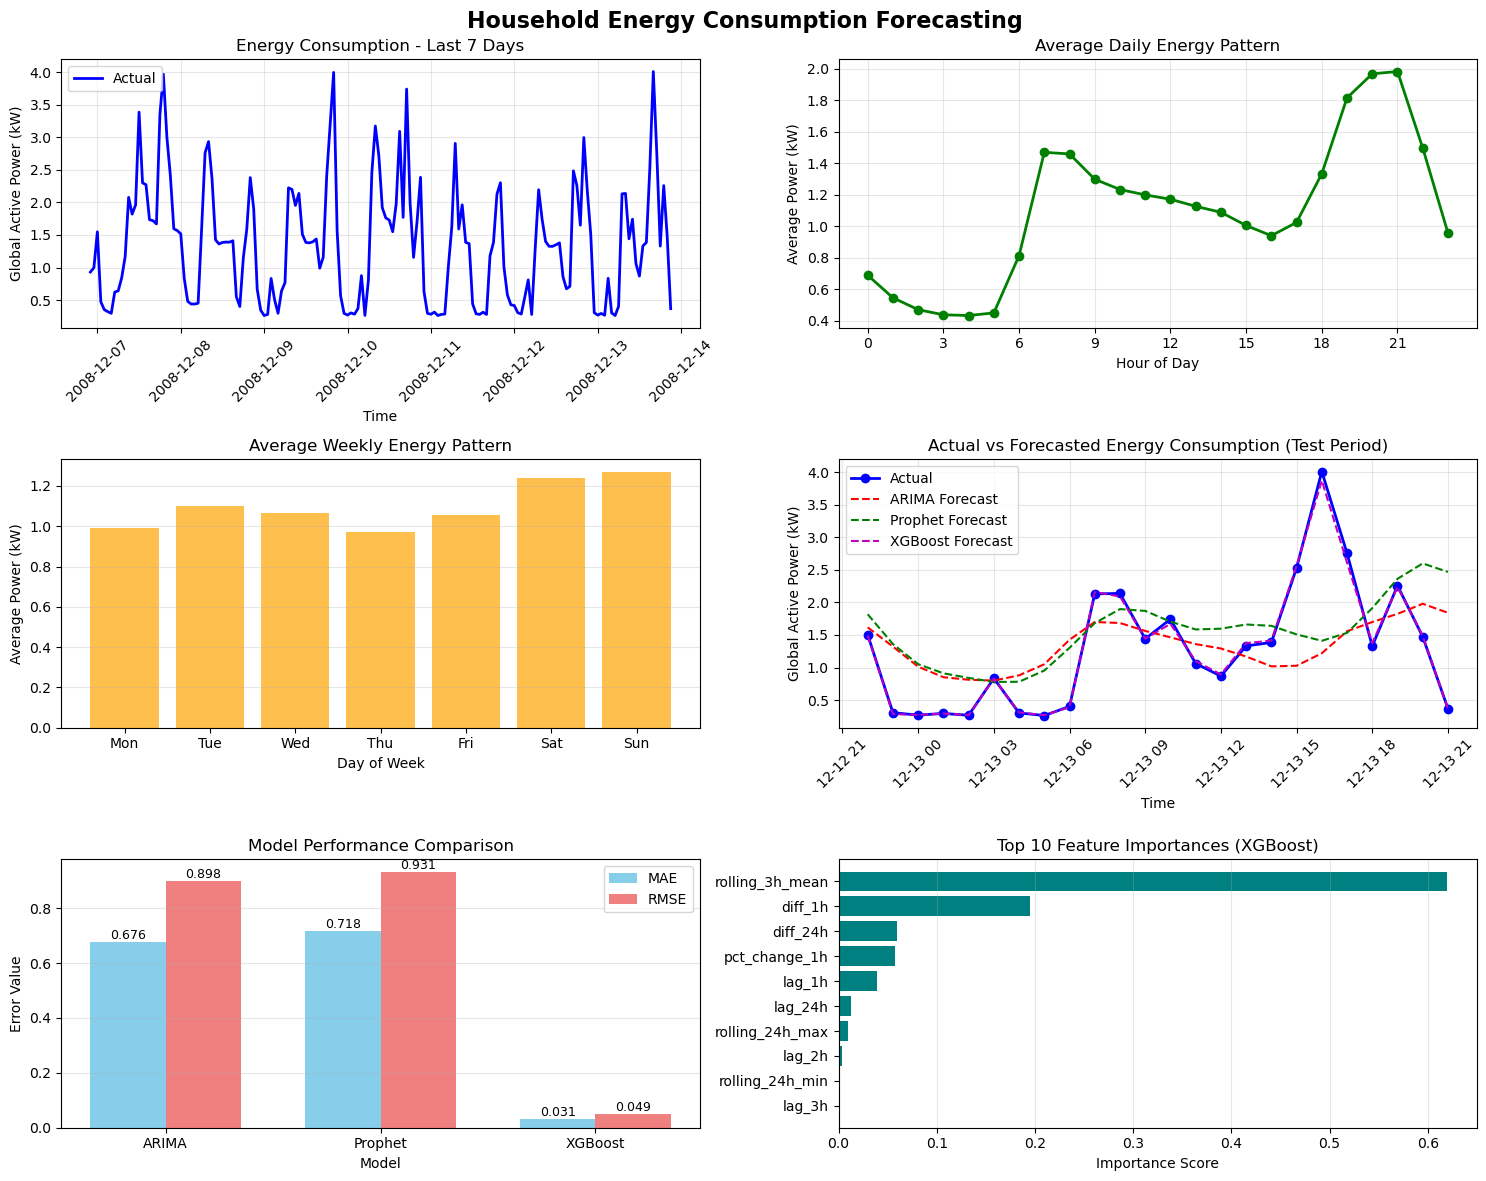

In [48]:
# VISUALIZATION 
print("VISUALIZATION")

# Create figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Household Energy Consumption Forecasting', fontsize=16, fontweight='bold')

# Plot 1: Original time series (last 7 days)
ax1 = axes[0, 0]
last_7_days = features_clean['energy'].iloc[-168:]  # Last week
ax1.plot(last_7_days.index, last_7_days.values, 'b-', linewidth=2, label='Actual')
ax1.set_title('Energy Consumption - Last 7 Days')
ax1.set_xlabel('Time')
ax1.set_ylabel('Global Active Power (kW)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Daily pattern
ax2 = axes[0, 1]
hourly_avg = features_clean.groupby('hour')['energy'].mean()
ax2.plot(hourly_avg.index, hourly_avg.values, 'g-', linewidth=2, marker='o')
ax2.set_title('Average Daily Energy Pattern')
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Average Power (kW)')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(range(0, 24, 3))

# Plot 3: Weekly pattern
ax3 = axes[1, 0]
weekday_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
weekly_avg = features_clean.groupby('day_of_week')['energy'].mean()
ax3.bar(weekday_names, weekly_avg.values, color='orange', alpha=0.7)
ax3.set_title('Average Weekly Energy Pattern')
ax3.set_xlabel('Day of Week')
ax3.set_ylabel('Average Power (kW)')
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Actual vs Forecasted comparison
ax4 = axes[1, 1]
ax4.plot(test.index, test['energy'].values, 'b-', linewidth=2, label='Actual', marker='o')

if arima_forecast is not None:
    ax4.plot(test.index, arima_forecast, 'r--', linewidth=1.5, label='ARIMA Forecast')
if prophet_forecast is not None:
    ax4.plot(test.index, prophet_forecast, 'g--', linewidth=1.5, label='Prophet Forecast')
if xgb_forecast is not None:
    ax4.plot(test.index, xgb_forecast, 'm--', linewidth=1.5, label='XGBoost Forecast')

ax4.set_title('Actual vs Forecasted Energy Consumption (Test Period)')
ax4.set_xlabel('Time')
ax4.set_ylabel('Global Active Power (kW)')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.tick_params(axis='x', rotation=45)

# Plot 5: Error comparison
ax5 = axes[2, 0]
models = ['ARIMA', 'Prophet', 'XGBoost']
mae_values = [arima_mae, prophet_mae, xgb_mae]
rmse_values = [arima_rmse, prophet_rmse, xgb_rmse]

x = np.arange(len(models))
width = 0.35

bars1 = ax5.bar(x - width/2, mae_values, width, label='MAE', color='skyblue')
bars2 = ax5.bar(x + width/2, rmse_values, width, label='RMSE', color='lightcoral')

ax5.set_title('Model Performance Comparison')
ax5.set_xlabel('Model')
ax5.set_ylabel('Error Value')
ax5.set_xticks(x)
ax5.set_xticklabels(models)
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height < np.inf:
            ax5.text(bar.get_x() + bar.get_width()/2, height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Plot 6: Feature importance (if XGBoost was successful)
ax6 = axes[2, 1]
if 'importance_df' in locals() and importance_df is not None:
    top_features = importance_df.head(10)
    ax6.barh(range(len(top_features)), top_features['importance'].values, color='teal')
    ax6.set_yticks(range(len(top_features)))
    ax6.set_yticklabels(top_features['feature'])
    ax6.set_title('Top 10 Feature Importances (XGBoost)')
    ax6.set_xlabel('Importance Score')
    ax6.invert_yaxis()  # Most important on top
else:
    ax6.text(0.5, 0.5, 'XGBoost feature importance\nnot available', 
             ha='center', va='center', transform=ax6.transAxes)
    ax6.set_title('Feature Importance')

ax6.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


In [50]:
# INSIGHTS AND SUMMARY
print("KEY INSIGHTS")

print("\n1. Data Characteristics:")
print(f"   - Time period: {features_clean.index.min().date()} to {features_clean.index.max().date()}")
print(f"   - Total hours: {len(features_clean)}")
print(f"   - Average power consumption: {features_clean['energy'].mean():.2f} kW")
print(f"   - Peak power consumption: {features_clean['energy'].max():.2f} kW")

print("\n2. Temporal Patterns:")
print(f"   - Peak hour: {hourly_avg.idxmax()}:00 ({hourly_avg.max():.2f} kW)")
print(f"   - Lowest hour: {hourly_avg.idxmin()}:00 ({hourly_avg.min():.2f} kW)")
print(f"   - Weekend consumption: {features_clean[features_clean['is_weekend']==1]['energy'].mean():.2f} kW")
print(f"   - Weekday consumption: {features_clean[features_clean['is_weekend']==0]['energy'].mean():.2f} kW")

print("\n3. Forecasting Recommendations:")
print(f"   - Best model: {best_model}")
print("   - Consider ensemble methods for improved accuracy")
print("   - Include weather data if available")
print("   - Monitor model performance during different seasons")

print("\n4. Next Steps:")
print("   - Collect more data for seasonal patterns")
print("   - Experiment with deep learning models (LSTM)")
print("   - Implement real-time forecasting pipeline")
print("   - Add anomaly detection for unusual consumption")

KEY INSIGHTS

1. Data Characteristics:
   - Time period: 2006-12-23 to 2008-12-13
   - Total hours: 17309
   - Average power consumption: 1.10 kW
   - Peak power consumption: 6.56 kW

2. Temporal Patterns:
   - Peak hour: 21:00 (1.98 kW)
   - Lowest hour: 4:00 (0.43 kW)
   - Weekend consumption: 1.25 kW
   - Weekday consumption: 1.04 kW

3. Forecasting Recommendations:
   - Best model: XGBoost
   - Consider ensemble methods for improved accuracy
   - Include weather data if available
   - Monitor model performance during different seasons

4. Next Steps:
   - Collect more data for seasonal patterns
   - Experiment with deep learning models (LSTM)
   - Implement real-time forecasting pipeline
   - Add anomaly detection for unusual consumption
